# Evaluation OpenAI as an annotator to replace the expert

In [2]:
from llama_index.llms import OpenAI
from openai import OpenAI
import json
import pandas as pd
from langchain import PromptTemplate
from tqdm import tqdm

Prepare Prompt For the OpenAI Evaluation

In [13]:
with open(
    "/home/lujun/local/causalllm/causal/creativity/creativity_eval/tests/ttcw_all_tests.json",
    "r",
) as f:
    tests = json.load(f)


def full_prompt2context(full_prompt):
    # remove the last two non-empty lines
    lines = full_prompt.strip().split("\n")
    kept1 = "\n".join(lines[:-1]).strip().split("\n")
    kept2 = kept1[:-1]
    return "\n".join(kept2).strip()


for test in tests:
    test["expanded_context"] = full_prompt2context(test["full_prompt"])

test_df = pd.DataFrame(tests)

In [38]:
evaluate_prompt = """You are given a creative short-story. Read it carefully. You are then given some background about specific aspects of creative writing, as well as a binary (Yes/No) question. Your objective is to use the background information to answer the question about the story. Start your answer with Yes or No. You can optionally then provide a short explanation for your answer.

==========
Story:
{story}
==========
Background:
{background}

==========
Question: {question}

Remember to start your answer with Yes or No. You can optionally then provide a short explanation for your answer.
"""

evaluate_prompt_template = PromptTemplate.from_template(evaluate_prompt)

In [39]:
import pandas as pd

stories_generated_df = pd.read_csv(
    "/home/lujun/local/causalllm/resource/creativity/text_generation_api_llama2_7B_4bit_creativity_500.csv"
)
print("stories_generated rows:", stories_generated_df.shape[0])
print("stories_generated columns:", stories_generated_df.columns)
print("test_df rows:", test_df.shape[0])
print("test_df columns:", test_df.columns)

cartesian_product_df = pd.merge(
    test_df.assign(key=0), stories_generated_df.assign(key=0), how="outer", on="key"
).drop("key", axis=1)

print("cartesian_product rows:", cartesian_product_df.shape[0])
print("cartesian_product columns:", cartesian_product_df.columns)

cartesian_product_df["formatted_prompt"] = cartesian_product_df.apply(
    lambda row: evaluate_prompt_template.format(
        story=row["generated_response"],
        background=row["expanded_context"],
        question=row["question"],
    ),
    axis=1,
)

stories_generated rows: 84
stories_generated columns: Index(['Unnamed: 0', 'story_idx', 'story_id', 'story_name', 'plot', 'content',
       'generated_response', 'timestamp', 'model', 'temperature'],
      dtype='object')
test_df rows: 14
test_df columns: Index(['ttcw_idx', 'torrance_dimension', 'category', 'question', 'full_prompt',
       'expanded_context'],
      dtype='object')
cartesian_product rows: 1176
cartesian_product columns: Index(['ttcw_idx', 'torrance_dimension', 'category', 'question', 'full_prompt',
       'expanded_context', 'Unnamed: 0', 'story_idx', 'story_id', 'story_name',
       'plot', 'content', 'generated_response', 'timestamp', 'model',
       'temperature'],
      dtype='object')


Start Evaluation Process

In [12]:
import os

evaluation_df = pd.read_csv(
    "/home/lujun/local/causalllm/resource/creativity/prompt_evaluation.csv"
)
csv_filename = (
    "/home/lujun/local/causalllm/resource/creativity/evaluation_annotation_GPT.csv"
)
api_key = os.getenv("OPENAI_API_KEY_FOYER")
generated_responses = []
client = OpenAI(api_key=api_key)
with tqdm(total=len(evaluation_df)) as pbar:
    for index, row in evaluation_df.iterrows():
        try:
            response = (
                client.chat.completions.create(
                    model="gpt-4-turbo",
                    messages=[
                        {
                            "role": "system",
                            "content": "You're an expert on creative writing.",
                        },
                        {"role": "user", "content": row["formatted_prompt"]},
                    ],
                )
                .choices[0]
                .message
            ).content
            generated_responses.append(response)
            updated_row = row.copy()
            updated_row["generated_response"] = response
            updated_dataframe = pd.DataFrame([updated_row])
            updated_dataframe.to_csv(
                csv_filename, index=False, mode="a", header=not index
            )
        except Exception as e:
            print(f"Error occurred for row {index}: {e}")
        pbar.update(1)

 42%|████▏     | 497/1176 [1:26:18<1:27:20,  7.72s/it]

Error occurred for row 496: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 42%|████▏     | 498/1176 [1:26:21<1:11:10,  6.30s/it]

Error occurred for row 497: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 42%|████▏     | 499/1176 [1:26:24<1:00:29,  5.36s/it]

Error occurred for row 498: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 500/1176 [1:26:28<53:45,  4.77s/it]  

Error occurred for row 499: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 501/1176 [1:26:31<48:47,  4.34s/it]

Error occurred for row 500: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 502/1176 [1:26:34<44:59,  4.00s/it]

Error occurred for row 501: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 503/1176 [1:26:37<41:04,  3.66s/it]

Error occurred for row 502: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 504/1176 [1:26:40<38:23,  3.43s/it]

Error occurred for row 503: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 505/1176 [1:26:43<36:43,  3.28s/it]

Error occurred for row 504: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 506/1176 [1:26:46<37:28,  3.36s/it]

Error occurred for row 505: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 507/1176 [1:26:49<36:32,  3.28s/it]

Error occurred for row 506: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 508/1176 [1:26:52<35:00,  3.14s/it]

Error occurred for row 507: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 509/1176 [1:26:55<35:01,  3.15s/it]

Error occurred for row 508: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 510/1176 [1:26:58<34:20,  3.09s/it]

Error occurred for row 509: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 43%|████▎     | 511/1176 [1:27:01<33:28,  3.02s/it]

Error occurred for row 510: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▎     | 512/1176 [1:27:05<34:06,  3.08s/it]

Error occurred for row 511: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▎     | 513/1176 [1:27:08<34:05,  3.09s/it]

Error occurred for row 512: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▎     | 514/1176 [1:27:11<34:02,  3.09s/it]

Error occurred for row 513: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 515/1176 [1:27:14<33:23,  3.03s/it]

Error occurred for row 514: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 516/1176 [1:27:17<33:09,  3.01s/it]

Error occurred for row 515: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 517/1176 [1:27:20<33:38,  3.06s/it]

Error occurred for row 516: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 518/1176 [1:27:23<34:26,  3.14s/it]

Error occurred for row 517: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 519/1176 [1:27:26<34:39,  3.17s/it]

Error occurred for row 518: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 520/1176 [1:27:29<34:32,  3.16s/it]

Error occurred for row 519: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 521/1176 [1:27:32<33:55,  3.11s/it]

Error occurred for row 520: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 522/1176 [1:27:36<34:28,  3.16s/it]

Error occurred for row 521: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 44%|████▍     | 523/1176 [1:27:39<34:19,  3.15s/it]

Error occurred for row 522: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 524/1176 [1:27:42<34:15,  3.15s/it]

Error occurred for row 523: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 525/1176 [1:27:45<33:14,  3.06s/it]

Error occurred for row 524: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 526/1176 [1:27:48<33:32,  3.10s/it]

Error occurred for row 525: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 527/1176 [1:27:51<33:18,  3.08s/it]

Error occurred for row 526: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 528/1176 [1:27:54<33:43,  3.12s/it]

Error occurred for row 527: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▍     | 529/1176 [1:27:57<33:53,  3.14s/it]

Error occurred for row 528: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 530/1176 [1:28:01<34:21,  3.19s/it]

Error occurred for row 529: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 531/1176 [1:28:04<34:38,  3.22s/it]

Error occurred for row 530: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 532/1176 [1:28:07<34:41,  3.23s/it]

Error occurred for row 531: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 533/1176 [1:28:11<34:27,  3.21s/it]

Error occurred for row 532: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 534/1176 [1:28:13<33:34,  3.14s/it]

Error occurred for row 533: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 45%|████▌     | 535/1176 [1:28:17<33:41,  3.15s/it]

Error occurred for row 534: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 536/1176 [1:28:20<33:40,  3.16s/it]

Error occurred for row 535: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 537/1176 [1:28:23<32:31,  3.05s/it]

Error occurred for row 536: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 538/1176 [1:28:26<32:47,  3.08s/it]

Error occurred for row 537: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 539/1176 [1:28:29<32:24,  3.05s/it]

Error occurred for row 538: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 540/1176 [1:28:32<32:27,  3.06s/it]

Error occurred for row 539: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 541/1176 [1:28:35<33:12,  3.14s/it]

Error occurred for row 540: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 542/1176 [1:28:38<32:36,  3.09s/it]

Error occurred for row 541: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▌     | 543/1176 [1:28:41<33:19,  3.16s/it]

Error occurred for row 542: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▋     | 544/1176 [1:28:45<33:04,  3.14s/it]

Error occurred for row 543: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▋     | 545/1176 [1:28:48<33:08,  3.15s/it]

Error occurred for row 544: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 46%|████▋     | 546/1176 [1:28:51<32:34,  3.10s/it]

Error occurred for row 545: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 547/1176 [1:28:54<33:05,  3.16s/it]

Error occurred for row 546: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 548/1176 [1:28:57<33:19,  3.18s/it]

Error occurred for row 547: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 549/1176 [1:29:00<32:07,  3.07s/it]

Error occurred for row 548: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 550/1176 [1:29:03<32:40,  3.13s/it]

Error occurred for row 549: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 551/1176 [1:29:07<33:37,  3.23s/it]

Error occurred for row 550: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 552/1176 [1:29:10<33:05,  3.18s/it]

Error occurred for row 551: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 553/1176 [1:29:13<33:24,  3.22s/it]

Error occurred for row 552: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 554/1176 [1:29:16<33:02,  3.19s/it]

Error occurred for row 553: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 555/1176 [1:29:19<32:55,  3.18s/it]

Error occurred for row 554: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 556/1176 [1:29:23<33:04,  3.20s/it]

Error occurred for row 555: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 557/1176 [1:29:26<33:05,  3.21s/it]

Error occurred for row 556: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 47%|████▋     | 558/1176 [1:29:29<32:48,  3.19s/it]

Error occurred for row 557: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 559/1176 [1:29:32<32:24,  3.15s/it]

Error occurred for row 558: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 560/1176 [1:29:35<32:22,  3.15s/it]

Error occurred for row 559: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 561/1176 [1:29:38<32:00,  3.12s/it]

Error occurred for row 560: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 562/1176 [1:29:41<31:10,  3.05s/it]

Error occurred for row 561: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 563/1176 [1:29:44<30:51,  3.02s/it]

Error occurred for row 562: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 564/1176 [1:29:47<31:21,  3.08s/it]

Error occurred for row 563: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 565/1176 [1:29:50<30:48,  3.03s/it]

Error occurred for row 564: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 566/1176 [1:29:53<31:12,  3.07s/it]

Error occurred for row 565: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 567/1176 [1:29:56<31:01,  3.06s/it]

Error occurred for row 566: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 568/1176 [1:29:59<30:40,  3.03s/it]

Error occurred for row 567: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 569/1176 [1:30:03<30:56,  3.06s/it]

Error occurred for row 568: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 48%|████▊     | 570/1176 [1:30:06<30:55,  3.06s/it]

Error occurred for row 569: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▊     | 571/1176 [1:30:09<30:51,  3.06s/it]

Error occurred for row 570: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▊     | 572/1176 [1:30:12<30:28,  3.03s/it]

Error occurred for row 571: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▊     | 573/1176 [1:30:15<30:17,  3.01s/it]

Error occurred for row 572: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 574/1176 [1:30:18<30:28,  3.04s/it]

Error occurred for row 573: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 575/1176 [1:30:21<31:19,  3.13s/it]

Error occurred for row 574: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 576/1176 [1:30:24<31:01,  3.10s/it]

Error occurred for row 575: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 577/1176 [1:30:27<31:33,  3.16s/it]

Error occurred for row 576: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 578/1176 [1:30:31<31:25,  3.15s/it]

Error occurred for row 577: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 579/1176 [1:30:34<31:37,  3.18s/it]

Error occurred for row 578: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 580/1176 [1:30:37<30:31,  3.07s/it]

Error occurred for row 579: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 581/1176 [1:30:40<30:51,  3.11s/it]

Error occurred for row 580: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 49%|████▉     | 582/1176 [1:30:43<30:27,  3.08s/it]

Error occurred for row 581: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|████▉     | 583/1176 [1:30:46<30:21,  3.07s/it]

Error occurred for row 582: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|████▉     | 584/1176 [1:30:49<30:19,  3.07s/it]

Error occurred for row 583: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|████▉     | 585/1176 [1:30:52<30:20,  3.08s/it]

Error occurred for row 584: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|████▉     | 586/1176 [1:30:55<29:35,  3.01s/it]

Error occurred for row 585: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|████▉     | 587/1176 [1:30:58<29:44,  3.03s/it]

Error occurred for row 586: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 588/1176 [1:31:01<29:35,  3.02s/it]

Error occurred for row 587: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 589/1176 [1:31:04<29:16,  2.99s/it]

Error occurred for row 588: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 590/1176 [1:31:07<29:31,  3.02s/it]

Error occurred for row 589: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 591/1176 [1:31:10<29:27,  3.02s/it]

Error occurred for row 590: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 592/1176 [1:31:13<29:11,  3.00s/it]

Error occurred for row 591: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 50%|█████     | 593/1176 [1:31:16<29:55,  3.08s/it]

Error occurred for row 592: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 594/1176 [1:31:20<30:36,  3.16s/it]

Error occurred for row 593: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 595/1176 [1:31:23<30:11,  3.12s/it]

Error occurred for row 594: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 596/1176 [1:31:25<29:17,  3.03s/it]

Error occurred for row 595: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 597/1176 [1:31:28<29:26,  3.05s/it]

Error occurred for row 596: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 598/1176 [1:31:32<30:02,  3.12s/it]

Error occurred for row 597: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 599/1176 [1:31:35<30:17,  3.15s/it]

Error occurred for row 598: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 600/1176 [1:31:38<31:01,  3.23s/it]

Error occurred for row 599: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 601/1176 [1:31:41<30:19,  3.16s/it]

Error occurred for row 600: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████     | 602/1176 [1:31:44<29:57,  3.13s/it]

Error occurred for row 601: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████▏    | 603/1176 [1:31:48<30:37,  3.21s/it]

Error occurred for row 602: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████▏    | 604/1176 [1:31:51<30:23,  3.19s/it]

Error occurred for row 603: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 51%|█████▏    | 605/1176 [1:31:54<29:49,  3.13s/it]

Error occurred for row 604: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 606/1176 [1:31:57<30:00,  3.16s/it]

Error occurred for row 605: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 607/1176 [1:32:00<28:54,  3.05s/it]

Error occurred for row 606: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 608/1176 [1:32:03<29:21,  3.10s/it]

Error occurred for row 607: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 609/1176 [1:32:06<29:08,  3.08s/it]

Error occurred for row 608: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 610/1176 [1:32:09<29:14,  3.10s/it]

Error occurred for row 609: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 611/1176 [1:32:13<29:31,  3.13s/it]

Error occurred for row 610: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 612/1176 [1:32:16<29:48,  3.17s/it]

Error occurred for row 611: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 613/1176 [1:32:19<28:49,  3.07s/it]

Error occurred for row 612: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 614/1176 [1:32:22<29:26,  3.14s/it]

Error occurred for row 613: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 615/1176 [1:32:25<28:20,  3.03s/it]

Error occurred for row 614: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 616/1176 [1:32:28<28:58,  3.11s/it]

Error occurred for row 615: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 52%|█████▏    | 617/1176 [1:32:31<29:06,  3.12s/it]

Error occurred for row 616: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 618/1176 [1:32:35<29:48,  3.21s/it]

Error occurred for row 617: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 619/1176 [1:32:38<28:45,  3.10s/it]

Error occurred for row 618: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 620/1176 [1:32:41<28:50,  3.11s/it]

Error occurred for row 619: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 621/1176 [1:32:43<27:55,  3.02s/it]

Error occurred for row 620: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 622/1176 [1:32:47<28:08,  3.05s/it]

Error occurred for row 621: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 623/1176 [1:32:50<28:22,  3.08s/it]

Error occurred for row 622: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 624/1176 [1:32:53<27:59,  3.04s/it]

Error occurred for row 623: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 625/1176 [1:32:56<28:31,  3.11s/it]

Error occurred for row 624: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 626/1176 [1:32:59<29:10,  3.18s/it]

Error occurred for row 625: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 627/1176 [1:33:03<29:11,  3.19s/it]

Error occurred for row 626: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 628/1176 [1:33:06<28:48,  3.15s/it]

Error occurred for row 627: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 53%|█████▎    | 629/1176 [1:33:09<29:27,  3.23s/it]

Error occurred for row 628: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▎    | 630/1176 [1:33:12<29:13,  3.21s/it]

Error occurred for row 629: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▎    | 631/1176 [1:33:15<28:19,  3.12s/it]

Error occurred for row 630: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▎    | 632/1176 [1:33:18<29:00,  3.20s/it]

Error occurred for row 631: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 633/1176 [1:33:21<28:22,  3.14s/it]

Error occurred for row 632: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 634/1176 [1:33:25<28:13,  3.13s/it]

Error occurred for row 633: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 635/1176 [1:33:28<28:03,  3.11s/it]

Error occurred for row 634: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 636/1176 [1:33:31<27:59,  3.11s/it]

Error occurred for row 635: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 637/1176 [1:33:34<27:33,  3.07s/it]

Error occurred for row 636: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 638/1176 [1:33:37<26:53,  3.00s/it]

Error occurred for row 637: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 639/1176 [1:33:39<26:45,  2.99s/it]

Error occurred for row 638: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 54%|█████▍    | 640/1176 [1:33:43<27:54,  3.12s/it]

Error occurred for row 639: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 641/1176 [1:33:46<28:15,  3.17s/it]

Error occurred for row 640: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 642/1176 [1:33:49<27:59,  3.14s/it]

Error occurred for row 641: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 643/1176 [1:33:52<27:21,  3.08s/it]

Error occurred for row 642: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 644/1176 [1:33:55<26:42,  3.01s/it]

Error occurred for row 643: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 645/1176 [1:33:58<26:01,  2.94s/it]

Error occurred for row 644: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▍    | 646/1176 [1:34:01<26:48,  3.03s/it]

Error occurred for row 645: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 647/1176 [1:34:04<27:10,  3.08s/it]

Error occurred for row 646: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 648/1176 [1:34:07<26:41,  3.03s/it]

Error occurred for row 647: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 649/1176 [1:34:10<27:18,  3.11s/it]

Error occurred for row 648: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 650/1176 [1:34:14<27:35,  3.15s/it]

Error occurred for row 649: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 651/1176 [1:34:17<27:17,  3.12s/it]

Error occurred for row 650: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 55%|█████▌    | 652/1176 [1:34:20<27:31,  3.15s/it]

Error occurred for row 651: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 653/1176 [1:34:23<26:57,  3.09s/it]

Error occurred for row 652: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 654/1176 [1:34:26<26:57,  3.10s/it]

Error occurred for row 653: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 655/1176 [1:34:29<26:35,  3.06s/it]

Error occurred for row 654: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 656/1176 [1:34:32<26:47,  3.09s/it]

Error occurred for row 655: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 657/1176 [1:34:36<27:29,  3.18s/it]

Error occurred for row 656: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 658/1176 [1:34:39<28:04,  3.25s/it]

Error occurred for row 657: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 659/1176 [1:34:42<27:42,  3.22s/it]

Error occurred for row 658: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 660/1176 [1:34:45<27:43,  3.22s/it]

Error occurred for row 659: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▌    | 661/1176 [1:34:48<27:18,  3.18s/it]

Error occurred for row 660: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▋    | 662/1176 [1:34:51<26:39,  3.11s/it]

Error occurred for row 661: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▋    | 663/1176 [1:34:55<28:12,  3.30s/it]

Error occurred for row 662: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 56%|█████▋    | 664/1176 [1:34:58<27:12,  3.19s/it]

Error occurred for row 663: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 665/1176 [1:35:01<27:20,  3.21s/it]

Error occurred for row 664: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 666/1176 [1:35:04<26:27,  3.11s/it]

Error occurred for row 665: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 667/1176 [1:35:07<26:09,  3.08s/it]

Error occurred for row 666: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 668/1176 [1:35:10<26:05,  3.08s/it]

Error occurred for row 667: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 669/1176 [1:35:14<26:31,  3.14s/it]

Error occurred for row 668: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 670/1176 [1:35:17<26:20,  3.12s/it]

Error occurred for row 669: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 671/1176 [1:35:20<26:16,  3.12s/it]

Error occurred for row 670: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 672/1176 [1:35:23<26:16,  3.13s/it]

Error occurred for row 671: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 673/1176 [1:35:26<26:12,  3.13s/it]

Error occurred for row 672: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 674/1176 [1:35:29<26:28,  3.16s/it]

Error occurred for row 673: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 675/1176 [1:35:32<26:17,  3.15s/it]

Error occurred for row 674: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 57%|█████▋    | 676/1176 [1:35:36<26:30,  3.18s/it]

Error occurred for row 675: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 677/1176 [1:35:39<26:52,  3.23s/it]

Error occurred for row 676: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 678/1176 [1:35:42<27:05,  3.26s/it]

Error occurred for row 677: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 679/1176 [1:35:46<26:44,  3.23s/it]

Error occurred for row 678: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 680/1176 [1:35:49<26:40,  3.23s/it]

Error occurred for row 679: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 681/1176 [1:35:52<26:30,  3.21s/it]

Error occurred for row 680: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 682/1176 [1:35:55<25:33,  3.10s/it]

Error occurred for row 681: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 683/1176 [1:35:58<24:48,  3.02s/it]

Error occurred for row 682: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 684/1176 [1:36:00<24:22,  2.97s/it]

Error occurred for row 683: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 685/1176 [1:36:04<25:02,  3.06s/it]

Error occurred for row 684: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 686/1176 [1:36:07<24:58,  3.06s/it]

Error occurred for row 685: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 58%|█████▊    | 687/1176 [1:36:10<24:46,  3.04s/it]

Error occurred for row 686: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▊    | 688/1176 [1:36:13<24:53,  3.06s/it]

Error occurred for row 687: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▊    | 689/1176 [1:36:16<25:11,  3.10s/it]

Error occurred for row 688: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▊    | 690/1176 [1:36:19<25:17,  3.12s/it]

Error occurred for row 689: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 691/1176 [1:36:23<25:33,  3.16s/it]

Error occurred for row 690: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 692/1176 [1:36:25<24:54,  3.09s/it]

Error occurred for row 691: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 693/1176 [1:36:29<25:22,  3.15s/it]

Error occurred for row 692: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 694/1176 [1:36:32<25:24,  3.16s/it]

Error occurred for row 693: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 695/1176 [1:36:35<24:55,  3.11s/it]

Error occurred for row 694: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 696/1176 [1:36:38<24:57,  3.12s/it]

Error occurred for row 695: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 697/1176 [1:36:41<24:36,  3.08s/it]

Error occurred for row 696: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 698/1176 [1:36:44<24:08,  3.03s/it]

Error occurred for row 697: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 59%|█████▉    | 699/1176 [1:36:47<24:19,  3.06s/it]

Error occurred for row 698: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 700/1176 [1:36:50<24:48,  3.13s/it]

Error occurred for row 699: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 701/1176 [1:36:53<24:15,  3.06s/it]

Error occurred for row 700: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 702/1176 [1:36:56<23:51,  3.02s/it]

Error occurred for row 701: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 703/1176 [1:37:00<24:36,  3.12s/it]

Error occurred for row 702: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 704/1176 [1:37:03<24:18,  3.09s/it]

Error occurred for row 703: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|█████▉    | 705/1176 [1:37:06<23:58,  3.05s/it]

Error occurred for row 704: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 706/1176 [1:37:09<24:13,  3.09s/it]

Error occurred for row 705: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 707/1176 [1:37:12<24:44,  3.17s/it]

Error occurred for row 706: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 708/1176 [1:37:16<25:19,  3.25s/it]

Error occurred for row 707: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 709/1176 [1:37:19<25:14,  3.24s/it]

Error occurred for row 708: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 710/1176 [1:37:22<25:07,  3.23s/it]

Error occurred for row 709: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 60%|██████    | 711/1176 [1:37:25<25:16,  3.26s/it]

Error occurred for row 710: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 712/1176 [1:37:28<24:31,  3.17s/it]

Error occurred for row 711: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 713/1176 [1:37:31<23:55,  3.10s/it]

Error occurred for row 712: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 714/1176 [1:37:34<24:07,  3.13s/it]

Error occurred for row 713: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 715/1176 [1:37:38<24:14,  3.16s/it]

Error occurred for row 714: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 716/1176 [1:37:41<23:59,  3.13s/it]

Error occurred for row 715: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 717/1176 [1:37:44<23:39,  3.09s/it]

Error occurred for row 716: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 718/1176 [1:37:47<23:57,  3.14s/it]

Error occurred for row 717: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 719/1176 [1:37:50<23:48,  3.12s/it]

Error occurred for row 718: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████    | 720/1176 [1:37:53<24:16,  3.19s/it]

Error occurred for row 719: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████▏   | 721/1176 [1:37:57<24:14,  3.20s/it]

Error occurred for row 720: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████▏   | 722/1176 [1:38:00<24:42,  3.26s/it]

Error occurred for row 721: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 61%|██████▏   | 723/1176 [1:38:03<23:47,  3.15s/it]

Error occurred for row 722: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 724/1176 [1:38:06<23:47,  3.16s/it]

Error occurred for row 723: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 725/1176 [1:38:09<23:14,  3.09s/it]

Error occurred for row 724: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 726/1176 [1:38:12<23:54,  3.19s/it]

Error occurred for row 725: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 727/1176 [1:38:15<23:24,  3.13s/it]

Error occurred for row 726: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 728/1176 [1:38:19<23:23,  3.13s/it]

Error occurred for row 727: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 729/1176 [1:38:22<23:49,  3.20s/it]

Error occurred for row 728: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 730/1176 [1:38:25<23:16,  3.13s/it]

Error occurred for row 729: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 731/1176 [1:38:28<23:37,  3.19s/it]

Error occurred for row 730: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 732/1176 [1:38:31<23:18,  3.15s/it]

Error occurred for row 731: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 733/1176 [1:38:34<23:02,  3.12s/it]

Error occurred for row 732: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▏   | 734/1176 [1:38:37<22:21,  3.03s/it]

Error occurred for row 733: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 62%|██████▎   | 735/1176 [1:38:40<22:12,  3.02s/it]

Error occurred for row 734: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 736/1176 [1:38:44<23:03,  3.14s/it]

Error occurred for row 735: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 737/1176 [1:38:47<23:21,  3.19s/it]

Error occurred for row 736: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 738/1176 [1:38:50<23:21,  3.20s/it]

Error occurred for row 737: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 739/1176 [1:38:53<23:21,  3.21s/it]

Error occurred for row 738: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 740/1176 [1:38:57<23:19,  3.21s/it]

Error occurred for row 739: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 741/1176 [1:39:00<23:13,  3.20s/it]

Error occurred for row 740: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 742/1176 [1:39:03<23:24,  3.24s/it]

Error occurred for row 741: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 743/1176 [1:39:06<23:11,  3.21s/it]

Error occurred for row 742: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 744/1176 [1:39:09<22:48,  3.17s/it]

Error occurred for row 743: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 745/1176 [1:39:13<23:08,  3.22s/it]

Error occurred for row 744: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 63%|██████▎   | 746/1176 [1:39:16<22:46,  3.18s/it]

Error occurred for row 745: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▎   | 747/1176 [1:39:19<22:25,  3.14s/it]

Error occurred for row 746: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▎   | 748/1176 [1:39:22<22:04,  3.10s/it]

Error occurred for row 747: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▎   | 749/1176 [1:39:25<21:34,  3.03s/it]

Error occurred for row 748: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 750/1176 [1:39:27<20:53,  2.94s/it]

Error occurred for row 749: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 751/1176 [1:39:31<21:43,  3.07s/it]

Error occurred for row 750: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 752/1176 [1:39:34<21:58,  3.11s/it]

Error occurred for row 751: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 753/1176 [1:39:37<21:53,  3.11s/it]

Error occurred for row 752: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 754/1176 [1:39:40<22:01,  3.13s/it]

Error occurred for row 753: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 755/1176 [1:39:43<21:53,  3.12s/it]

Error occurred for row 754: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 756/1176 [1:39:46<21:29,  3.07s/it]

Error occurred for row 755: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 757/1176 [1:39:49<21:51,  3.13s/it]

Error occurred for row 756: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 64%|██████▍   | 758/1176 [1:39:53<21:41,  3.11s/it]

Error occurred for row 757: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 759/1176 [1:39:56<22:42,  3.27s/it]

Error occurred for row 758: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 760/1176 [1:39:59<22:37,  3.26s/it]

Error occurred for row 759: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 761/1176 [1:40:03<22:23,  3.24s/it]

Error occurred for row 760: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 762/1176 [1:40:06<21:40,  3.14s/it]

Error occurred for row 761: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 763/1176 [1:40:09<21:40,  3.15s/it]

Error occurred for row 762: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▍   | 764/1176 [1:40:12<21:41,  3.16s/it]

Error occurred for row 763: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 765/1176 [1:40:15<21:42,  3.17s/it]

Error occurred for row 764: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 766/1176 [1:40:18<21:32,  3.15s/it]

Error occurred for row 765: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 767/1176 [1:40:21<21:35,  3.17s/it]

Error occurred for row 766: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 768/1176 [1:40:25<21:29,  3.16s/it]

Error occurred for row 767: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 769/1176 [1:40:28<21:03,  3.10s/it]

Error occurred for row 768: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 65%|██████▌   | 770/1176 [1:40:31<21:16,  3.14s/it]

Error occurred for row 769: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 771/1176 [1:40:34<21:40,  3.21s/it]

Error occurred for row 770: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 772/1176 [1:40:37<21:06,  3.14s/it]

Error occurred for row 771: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 773/1176 [1:40:40<21:00,  3.13s/it]

Error occurred for row 772: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 774/1176 [1:40:44<21:28,  3.20s/it]

Error occurred for row 773: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 775/1176 [1:40:46<20:52,  3.12s/it]

Error occurred for row 774: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 776/1176 [1:40:49<20:31,  3.08s/it]

Error occurred for row 775: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 777/1176 [1:40:53<20:38,  3.10s/it]

Error occurred for row 776: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 778/1176 [1:40:56<21:18,  3.21s/it]

Error occurred for row 777: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▌   | 779/1176 [1:40:59<21:30,  3.25s/it]

Error occurred for row 778: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▋   | 780/1176 [1:41:02<20:49,  3.15s/it]

Error occurred for row 779: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▋   | 781/1176 [1:41:05<20:24,  3.10s/it]

Error occurred for row 780: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 66%|██████▋   | 782/1176 [1:41:08<20:19,  3.10s/it]

Error occurred for row 781: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 783/1176 [1:41:12<20:15,  3.09s/it]

Error occurred for row 782: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 784/1176 [1:41:14<19:57,  3.05s/it]

Error occurred for row 783: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 785/1176 [1:41:17<19:23,  2.97s/it]

Error occurred for row 784: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 786/1176 [1:41:20<19:30,  3.00s/it]

Error occurred for row 785: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 787/1176 [1:41:23<19:39,  3.03s/it]

Error occurred for row 786: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 788/1176 [1:41:26<19:39,  3.04s/it]

Error occurred for row 787: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 789/1176 [1:41:30<20:05,  3.11s/it]

Error occurred for row 788: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 790/1176 [1:41:33<20:12,  3.14s/it]

Error occurred for row 789: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 791/1176 [1:41:36<20:08,  3.14s/it]

Error occurred for row 790: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 792/1176 [1:41:39<20:12,  3.16s/it]

Error occurred for row 791: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 67%|██████▋   | 793/1176 [1:41:43<20:38,  3.23s/it]

Error occurred for row 792: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 794/1176 [1:41:46<20:44,  3.26s/it]

Error occurred for row 793: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 795/1176 [1:41:49<20:11,  3.18s/it]

Error occurred for row 794: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 796/1176 [1:41:52<20:08,  3.18s/it]

Error occurred for row 795: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 797/1176 [1:41:55<20:12,  3.20s/it]

Error occurred for row 796: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 798/1176 [1:41:58<19:48,  3.14s/it]

Error occurred for row 797: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 799/1176 [1:42:02<19:49,  3.15s/it]

Error occurred for row 798: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 800/1176 [1:42:04<19:02,  3.04s/it]

Error occurred for row 799: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 801/1176 [1:42:07<18:39,  2.98s/it]

Error occurred for row 800: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 802/1176 [1:42:11<19:15,  3.09s/it]

Error occurred for row 801: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 803/1176 [1:42:14<19:22,  3.12s/it]

Error occurred for row 802: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 804/1176 [1:42:17<19:11,  3.09s/it]

Error occurred for row 803: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 68%|██████▊   | 805/1176 [1:42:20<18:53,  3.06s/it]

Error occurred for row 804: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▊   | 806/1176 [1:42:23<19:06,  3.10s/it]

Error occurred for row 805: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▊   | 807/1176 [1:42:26<19:33,  3.18s/it]

Error occurred for row 806: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▊   | 808/1176 [1:42:30<19:54,  3.25s/it]

Error occurred for row 807: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 809/1176 [1:42:33<19:12,  3.14s/it]

Error occurred for row 808: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 810/1176 [1:42:36<18:53,  3.10s/it]

Error occurred for row 809: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 811/1176 [1:42:39<19:29,  3.20s/it]

Error occurred for row 810: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 812/1176 [1:42:42<18:52,  3.11s/it]

Error occurred for row 811: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 813/1176 [1:42:45<18:28,  3.05s/it]

Error occurred for row 812: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 814/1176 [1:42:48<18:13,  3.02s/it]

Error occurred for row 813: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 815/1176 [1:42:51<18:11,  3.02s/it]

Error occurred for row 814: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 816/1176 [1:42:54<17:49,  2.97s/it]

Error occurred for row 815: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 69%|██████▉   | 817/1176 [1:42:57<17:57,  3.00s/it]

Error occurred for row 816: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 818/1176 [1:43:00<18:07,  3.04s/it]

Error occurred for row 817: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 819/1176 [1:43:03<18:42,  3.14s/it]

Error occurred for row 818: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 820/1176 [1:43:06<18:38,  3.14s/it]

Error occurred for row 819: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 821/1176 [1:43:10<18:49,  3.18s/it]

Error occurred for row 820: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 822/1176 [1:43:13<18:19,  3.11s/it]

Error occurred for row 821: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|██████▉   | 823/1176 [1:43:16<18:50,  3.20s/it]

Error occurred for row 822: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 824/1176 [1:43:19<18:27,  3.15s/it]

Error occurred for row 823: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 825/1176 [1:43:22<17:54,  3.06s/it]

Error occurred for row 824: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 826/1176 [1:43:25<18:09,  3.11s/it]

Error occurred for row 825: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 827/1176 [1:43:28<17:52,  3.07s/it]

Error occurred for row 826: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 828/1176 [1:43:31<17:44,  3.06s/it]

Error occurred for row 827: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 70%|███████   | 829/1176 [1:43:34<17:51,  3.09s/it]

Error occurred for row 828: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 830/1176 [1:43:37<17:17,  3.00s/it]

Error occurred for row 829: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 831/1176 [1:43:40<17:26,  3.03s/it]

Error occurred for row 830: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 832/1176 [1:43:44<18:00,  3.14s/it]

Error occurred for row 831: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 833/1176 [1:43:47<18:04,  3.16s/it]

Error occurred for row 832: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 834/1176 [1:43:50<17:45,  3.11s/it]

Error occurred for row 833: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 835/1176 [1:43:53<17:56,  3.16s/it]

Error occurred for row 834: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 836/1176 [1:43:56<17:37,  3.11s/it]

Error occurred for row 835: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████   | 837/1176 [1:43:59<17:33,  3.11s/it]

Error occurred for row 836: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████▏  | 838/1176 [1:44:02<17:00,  3.02s/it]

Error occurred for row 837: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████▏  | 839/1176 [1:44:05<17:19,  3.08s/it]

Error occurred for row 838: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 71%|███████▏  | 840/1176 [1:44:08<16:54,  3.02s/it]

Error occurred for row 839: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 841/1176 [1:44:11<17:11,  3.08s/it]

Error occurred for row 840: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 842/1176 [1:44:14<16:53,  3.04s/it]

Error occurred for row 841: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 843/1176 [1:44:18<17:12,  3.10s/it]

Error occurred for row 842: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 844/1176 [1:44:21<17:11,  3.11s/it]

Error occurred for row 843: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 845/1176 [1:44:24<17:13,  3.12s/it]

Error occurred for row 844: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 846/1176 [1:44:27<17:23,  3.16s/it]

Error occurred for row 845: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 847/1176 [1:44:30<16:53,  3.08s/it]

Error occurred for row 846: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 848/1176 [1:44:33<16:50,  3.08s/it]

Error occurred for row 847: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 849/1176 [1:44:36<16:42,  3.06s/it]

Error occurred for row 848: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 850/1176 [1:44:39<16:33,  3.05s/it]

Error occurred for row 849: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 851/1176 [1:44:42<15:59,  2.95s/it]

Error occurred for row 850: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 72%|███████▏  | 852/1176 [1:44:45<16:11,  3.00s/it]

Error occurred for row 851: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 853/1176 [1:44:48<16:38,  3.09s/it]

Error occurred for row 852: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 854/1176 [1:44:51<16:08,  3.01s/it]

Error occurred for row 853: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 855/1176 [1:44:54<15:53,  2.97s/it]

Error occurred for row 854: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 856/1176 [1:44:57<15:37,  2.93s/it]

Error occurred for row 855: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 857/1176 [1:45:00<15:27,  2.91s/it]

Error occurred for row 856: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 858/1176 [1:45:03<15:32,  2.93s/it]

Error occurred for row 857: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 859/1176 [1:45:06<15:44,  2.98s/it]

Error occurred for row 858: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 860/1176 [1:45:09<15:31,  2.95s/it]

Error occurred for row 859: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 861/1176 [1:45:12<15:58,  3.04s/it]

Error occurred for row 860: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 862/1176 [1:45:15<16:28,  3.15s/it]

Error occurred for row 861: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 863/1176 [1:45:18<16:00,  3.07s/it]

Error occurred for row 862: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 73%|███████▎  | 864/1176 [1:45:21<15:56,  3.07s/it]

Error occurred for row 863: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▎  | 865/1176 [1:45:25<16:27,  3.17s/it]

Error occurred for row 864: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▎  | 866/1176 [1:45:27<15:52,  3.07s/it]

Error occurred for row 865: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▎  | 867/1176 [1:45:31<16:06,  3.13s/it]

Error occurred for row 866: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 868/1176 [1:45:34<15:51,  3.09s/it]

Error occurred for row 867: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 869/1176 [1:45:37<15:41,  3.07s/it]

Error occurred for row 868: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 870/1176 [1:45:40<15:17,  3.00s/it]

Error occurred for row 869: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 871/1176 [1:45:43<15:37,  3.07s/it]

Error occurred for row 870: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 872/1176 [1:45:46<15:32,  3.07s/it]

Error occurred for row 871: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 873/1176 [1:45:49<15:57,  3.16s/it]

Error occurred for row 872: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 874/1176 [1:45:52<15:44,  3.13s/it]

Error occurred for row 873: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 875/1176 [1:45:55<15:38,  3.12s/it]

Error occurred for row 874: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 74%|███████▍  | 876/1176 [1:45:59<15:37,  3.12s/it]

Error occurred for row 875: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▍  | 877/1176 [1:46:02<15:42,  3.15s/it]

Error occurred for row 876: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▍  | 878/1176 [1:46:05<15:46,  3.18s/it]

Error occurred for row 877: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▍  | 879/1176 [1:46:08<15:18,  3.09s/it]

Error occurred for row 878: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▍  | 880/1176 [1:46:11<15:07,  3.07s/it]

Error occurred for row 879: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▍  | 881/1176 [1:46:14<14:59,  3.05s/it]

Error occurred for row 880: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 882/1176 [1:46:17<14:51,  3.03s/it]

Error occurred for row 881: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 883/1176 [1:46:20<15:08,  3.10s/it]

Error occurred for row 882: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 884/1176 [1:46:23<15:20,  3.15s/it]

Error occurred for row 883: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 885/1176 [1:46:26<15:03,  3.11s/it]

Error occurred for row 884: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 886/1176 [1:46:29<14:46,  3.06s/it]

Error occurred for row 885: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 75%|███████▌  | 887/1176 [1:46:33<14:52,  3.09s/it]

Error occurred for row 886: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 888/1176 [1:46:36<15:03,  3.14s/it]

Error occurred for row 887: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 889/1176 [1:46:39<15:23,  3.22s/it]

Error occurred for row 888: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 890/1176 [1:46:42<14:45,  3.09s/it]

Error occurred for row 889: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 891/1176 [1:46:45<14:53,  3.14s/it]

Error occurred for row 890: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 892/1176 [1:46:48<14:38,  3.09s/it]

Error occurred for row 891: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 893/1176 [1:46:51<14:43,  3.12s/it]

Error occurred for row 892: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 894/1176 [1:46:55<14:40,  3.12s/it]

Error occurred for row 893: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 895/1176 [1:46:57<14:18,  3.05s/it]

Error occurred for row 894: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▌  | 896/1176 [1:47:01<14:36,  3.13s/it]

Error occurred for row 895: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▋  | 897/1176 [1:47:04<14:32,  3.13s/it]

Error occurred for row 896: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▋  | 898/1176 [1:47:07<14:19,  3.09s/it]

Error occurred for row 897: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 76%|███████▋  | 899/1176 [1:47:10<14:19,  3.10s/it]

Error occurred for row 898: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 900/1176 [1:47:13<14:10,  3.08s/it]

Error occurred for row 899: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 901/1176 [1:47:16<14:16,  3.11s/it]

Error occurred for row 900: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 902/1176 [1:47:20<14:33,  3.19s/it]

Error occurred for row 901: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 903/1176 [1:47:23<14:35,  3.21s/it]

Error occurred for row 902: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 904/1176 [1:47:26<14:47,  3.26s/it]

Error occurred for row 903: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 905/1176 [1:47:29<14:39,  3.25s/it]

Error occurred for row 904: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 906/1176 [1:47:32<14:09,  3.15s/it]

Error occurred for row 905: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 907/1176 [1:47:35<14:06,  3.15s/it]

Error occurred for row 906: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 908/1176 [1:47:39<13:58,  3.13s/it]

Error occurred for row 907: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 909/1176 [1:47:42<13:49,  3.11s/it]

Error occurred for row 908: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 910/1176 [1:47:45<14:13,  3.21s/it]

Error occurred for row 909: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 77%|███████▋  | 911/1176 [1:47:48<14:11,  3.21s/it]

Error occurred for row 910: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 912/1176 [1:47:51<13:36,  3.09s/it]

Error occurred for row 911: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 913/1176 [1:47:54<13:18,  3.03s/it]

Error occurred for row 912: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 914/1176 [1:47:57<13:12,  3.03s/it]

Error occurred for row 913: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 915/1176 [1:48:00<13:22,  3.07s/it]

Error occurred for row 914: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 916/1176 [1:48:03<13:25,  3.10s/it]

Error occurred for row 915: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 917/1176 [1:48:06<13:16,  3.08s/it]

Error occurred for row 916: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 918/1176 [1:48:10<13:22,  3.11s/it]

Error occurred for row 917: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 919/1176 [1:48:13<13:11,  3.08s/it]

Error occurred for row 918: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 920/1176 [1:48:15<12:49,  3.01s/it]

Error occurred for row 919: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 921/1176 [1:48:18<12:49,  3.02s/it]

Error occurred for row 920: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 922/1176 [1:48:22<13:01,  3.08s/it]

Error occurred for row 921: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 78%|███████▊  | 923/1176 [1:48:25<13:11,  3.13s/it]

Error occurred for row 922: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▊  | 924/1176 [1:48:28<13:24,  3.19s/it]

Error occurred for row 923: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▊  | 925/1176 [1:48:31<13:22,  3.20s/it]

Error occurred for row 924: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▊  | 926/1176 [1:48:34<12:53,  3.09s/it]

Error occurred for row 925: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 927/1176 [1:48:37<12:45,  3.07s/it]

Error occurred for row 926: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 928/1176 [1:48:40<12:29,  3.02s/it]

Error occurred for row 927: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 929/1176 [1:48:43<12:16,  2.98s/it]

Error occurred for row 928: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 930/1176 [1:48:46<12:19,  3.00s/it]

Error occurred for row 929: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 931/1176 [1:48:50<12:47,  3.13s/it]

Error occurred for row 930: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 932/1176 [1:48:53<12:58,  3.19s/it]

Error occurred for row 931: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 933/1176 [1:48:56<12:59,  3.21s/it]

Error occurred for row 932: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 79%|███████▉  | 934/1176 [1:48:59<12:30,  3.10s/it]

Error occurred for row 933: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 935/1176 [1:49:02<12:40,  3.15s/it]

Error occurred for row 934: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 936/1176 [1:49:06<12:47,  3.20s/it]

Error occurred for row 935: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 937/1176 [1:49:09<12:53,  3.24s/it]

Error occurred for row 936: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 938/1176 [1:49:12<12:30,  3.15s/it]

Error occurred for row 937: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 939/1176 [1:49:15<12:16,  3.11s/it]

Error occurred for row 938: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|███████▉  | 940/1176 [1:49:18<11:58,  3.05s/it]

Error occurred for row 939: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 941/1176 [1:49:21<12:12,  3.12s/it]

Error occurred for row 940: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 942/1176 [1:49:24<11:47,  3.02s/it]

Error occurred for row 941: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 943/1176 [1:49:27<12:12,  3.14s/it]

Error occurred for row 942: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 944/1176 [1:49:30<11:59,  3.10s/it]

Error occurred for row 943: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 945/1176 [1:49:34<12:09,  3.16s/it]

Error occurred for row 944: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 80%|████████  | 946/1176 [1:49:37<11:54,  3.10s/it]

Error occurred for row 945: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 947/1176 [1:49:40<11:54,  3.12s/it]

Error occurred for row 946: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 948/1176 [1:49:43<11:47,  3.10s/it]

Error occurred for row 947: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 949/1176 [1:49:46<12:12,  3.23s/it]

Error occurred for row 948: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 950/1176 [1:49:49<11:57,  3.18s/it]

Error occurred for row 949: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 951/1176 [1:49:52<11:29,  3.06s/it]

Error occurred for row 950: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 952/1176 [1:49:55<11:23,  3.05s/it]

Error occurred for row 951: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 953/1176 [1:49:58<11:09,  3.00s/it]

Error occurred for row 952: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 954/1176 [1:50:01<11:21,  3.07s/it]

Error occurred for row 953: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████  | 955/1176 [1:50:04<11:21,  3.08s/it]

Error occurred for row 954: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████▏ | 956/1176 [1:50:08<11:25,  3.11s/it]

Error occurred for row 955: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████▏ | 957/1176 [1:50:11<11:22,  3.12s/it]

Error occurred for row 956: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 81%|████████▏ | 958/1176 [1:50:14<11:28,  3.16s/it]

Error occurred for row 957: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 959/1176 [1:50:17<11:16,  3.12s/it]

Error occurred for row 958: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 960/1176 [1:50:20<11:06,  3.09s/it]

Error occurred for row 959: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 961/1176 [1:50:23<11:10,  3.12s/it]

Error occurred for row 960: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 962/1176 [1:50:26<10:48,  3.03s/it]

Error occurred for row 961: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 963/1176 [1:50:29<10:51,  3.06s/it]

Error occurred for row 962: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 964/1176 [1:50:32<10:56,  3.10s/it]

Error occurred for row 963: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 965/1176 [1:50:35<10:49,  3.08s/it]

Error occurred for row 964: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 966/1176 [1:50:39<11:05,  3.17s/it]

Error occurred for row 965: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 967/1176 [1:50:42<11:12,  3.22s/it]

Error occurred for row 966: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 968/1176 [1:50:45<11:06,  3.20s/it]

Error occurred for row 967: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 969/1176 [1:50:48<10:41,  3.10s/it]

Error occurred for row 968: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 82%|████████▏ | 970/1176 [1:50:51<10:44,  3.13s/it]

Error occurred for row 969: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 971/1176 [1:50:54<10:29,  3.07s/it]

Error occurred for row 970: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 972/1176 [1:50:57<10:19,  3.04s/it]

Error occurred for row 971: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 973/1176 [1:51:00<10:16,  3.04s/it]

Error occurred for row 972: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 974/1176 [1:51:03<10:22,  3.08s/it]

Error occurred for row 973: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 975/1176 [1:51:07<10:25,  3.11s/it]

Error occurred for row 974: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 976/1176 [1:51:10<10:25,  3.13s/it]

Error occurred for row 975: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 977/1176 [1:51:13<10:26,  3.15s/it]

Error occurred for row 976: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 978/1176 [1:51:16<10:26,  3.16s/it]

Error occurred for row 977: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 979/1176 [1:51:19<10:13,  3.11s/it]

Error occurred for row 978: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 980/1176 [1:51:22<10:06,  3.10s/it]

Error occurred for row 979: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 83%|████████▎ | 981/1176 [1:51:25<10:03,  3.10s/it]

Error occurred for row 980: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▎ | 982/1176 [1:51:29<10:19,  3.19s/it]

Error occurred for row 981: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▎ | 983/1176 [1:51:32<09:54,  3.08s/it]

Error occurred for row 982: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▎ | 984/1176 [1:51:35<09:57,  3.11s/it]

Error occurred for row 983: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 985/1176 [1:51:38<09:35,  3.01s/it]

Error occurred for row 984: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 986/1176 [1:51:41<09:35,  3.03s/it]

Error occurred for row 985: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 987/1176 [1:51:44<09:40,  3.07s/it]

Error occurred for row 986: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 988/1176 [1:51:47<09:45,  3.11s/it]

Error occurred for row 987: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 989/1176 [1:51:50<09:39,  3.10s/it]

Error occurred for row 988: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 990/1176 [1:51:53<09:49,  3.17s/it]

Error occurred for row 989: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 991/1176 [1:51:56<09:36,  3.12s/it]

Error occurred for row 990: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 992/1176 [1:51:59<09:21,  3.05s/it]

Error occurred for row 991: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 84%|████████▍ | 993/1176 [1:52:02<09:25,  3.09s/it]

Error occurred for row 992: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 994/1176 [1:52:06<09:29,  3.13s/it]

Error occurred for row 993: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 995/1176 [1:52:09<09:35,  3.18s/it]

Error occurred for row 994: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 996/1176 [1:52:12<09:35,  3.20s/it]

Error occurred for row 995: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 997/1176 [1:52:15<09:21,  3.14s/it]

Error occurred for row 996: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 998/1176 [1:52:18<09:12,  3.10s/it]

Error occurred for row 997: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▍ | 999/1176 [1:52:22<09:16,  3.14s/it]

Error occurred for row 998: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1000/1176 [1:52:25<09:22,  3.20s/it]

Error occurred for row 999: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1001/1176 [1:52:28<09:18,  3.19s/it]

Error occurred for row 1000: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1002/1176 [1:52:31<09:08,  3.15s/it]

Error occurred for row 1001: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1003/1176 [1:52:34<09:08,  3.17s/it]

Error occurred for row 1002: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1004/1176 [1:52:38<09:12,  3.21s/it]

Error occurred for row 1003: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 85%|████████▌ | 1005/1176 [1:52:40<08:47,  3.08s/it]

Error occurred for row 1004: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1006/1176 [1:52:44<08:54,  3.14s/it]

Error occurred for row 1005: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1007/1176 [1:52:47<09:04,  3.22s/it]

Error occurred for row 1006: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1008/1176 [1:52:50<08:54,  3.18s/it]

Error occurred for row 1007: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1009/1176 [1:52:53<08:27,  3.04s/it]

Error occurred for row 1008: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1010/1176 [1:52:56<08:23,  3.03s/it]

Error occurred for row 1009: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1011/1176 [1:52:59<08:05,  2.94s/it]

Error occurred for row 1010: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1012/1176 [1:53:02<08:22,  3.07s/it]

Error occurred for row 1011: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1013/1176 [1:53:05<08:22,  3.08s/it]

Error occurred for row 1012: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▌ | 1014/1176 [1:53:08<08:14,  3.05s/it]

Error occurred for row 1013: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▋ | 1015/1176 [1:53:11<08:07,  3.03s/it]

Error occurred for row 1014: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▋ | 1016/1176 [1:53:14<08:06,  3.04s/it]

Error occurred for row 1015: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 86%|████████▋ | 1017/1176 [1:53:17<08:18,  3.14s/it]

Error occurred for row 1016: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1018/1176 [1:53:20<08:09,  3.10s/it]

Error occurred for row 1017: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1019/1176 [1:53:24<08:11,  3.13s/it]

Error occurred for row 1018: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1020/1176 [1:53:27<08:02,  3.09s/it]

Error occurred for row 1019: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1021/1176 [1:53:30<08:04,  3.13s/it]

Error occurred for row 1020: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1022/1176 [1:53:33<07:51,  3.06s/it]

Error occurred for row 1021: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1023/1176 [1:53:36<07:58,  3.13s/it]

Error occurred for row 1022: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1024/1176 [1:53:39<07:58,  3.15s/it]

Error occurred for row 1023: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1025/1176 [1:53:43<08:05,  3.22s/it]

Error occurred for row 1024: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1026/1176 [1:53:46<07:47,  3.12s/it]

Error occurred for row 1025: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1027/1176 [1:53:49<07:51,  3.16s/it]

Error occurred for row 1026: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 87%|████████▋ | 1028/1176 [1:53:52<07:52,  3.19s/it]

Error occurred for row 1027: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1029/1176 [1:53:55<07:42,  3.15s/it]

Error occurred for row 1028: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1030/1176 [1:53:58<07:41,  3.16s/it]

Error occurred for row 1029: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1031/1176 [1:54:01<07:38,  3.16s/it]

Error occurred for row 1030: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1032/1176 [1:54:05<07:31,  3.13s/it]

Error occurred for row 1031: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1033/1176 [1:54:08<07:22,  3.10s/it]

Error occurred for row 1032: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1034/1176 [1:54:11<07:32,  3.19s/it]

Error occurred for row 1033: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1035/1176 [1:54:14<07:36,  3.24s/it]

Error occurred for row 1034: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1036/1176 [1:54:18<07:34,  3.25s/it]

Error occurred for row 1035: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1037/1176 [1:54:21<07:23,  3.19s/it]

Error occurred for row 1036: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1038/1176 [1:54:24<07:19,  3.18s/it]

Error occurred for row 1037: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1039/1176 [1:54:27<07:02,  3.08s/it]

Error occurred for row 1038: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 88%|████████▊ | 1040/1176 [1:54:30<06:55,  3.06s/it]

Error occurred for row 1039: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▊ | 1041/1176 [1:54:33<06:55,  3.08s/it]

Error occurred for row 1040: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▊ | 1042/1176 [1:54:36<06:49,  3.05s/it]

Error occurred for row 1041: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▊ | 1043/1176 [1:54:39<06:51,  3.10s/it]

Error occurred for row 1042: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1044/1176 [1:54:42<06:56,  3.15s/it]

Error occurred for row 1043: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1045/1176 [1:54:45<06:50,  3.13s/it]

Error occurred for row 1044: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1046/1176 [1:54:48<06:45,  3.12s/it]

Error occurred for row 1045: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1047/1176 [1:54:52<06:46,  3.15s/it]

Error occurred for row 1046: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1048/1176 [1:54:55<06:50,  3.21s/it]

Error occurred for row 1047: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1049/1176 [1:54:58<06:36,  3.12s/it]

Error occurred for row 1048: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1050/1176 [1:55:01<06:37,  3.16s/it]

Error occurred for row 1049: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1051/1176 [1:55:04<06:22,  3.06s/it]

Error occurred for row 1050: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 89%|████████▉ | 1052/1176 [1:55:07<06:24,  3.10s/it]

Error occurred for row 1051: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1053/1176 [1:55:10<06:11,  3.02s/it]

Error occurred for row 1052: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1054/1176 [1:55:13<06:16,  3.08s/it]

Error occurred for row 1053: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1055/1176 [1:55:16<06:17,  3.12s/it]

Error occurred for row 1054: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1056/1176 [1:55:19<06:12,  3.10s/it]

Error occurred for row 1055: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1057/1176 [1:55:23<06:12,  3.13s/it]

Error occurred for row 1056: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|████████▉ | 1058/1176 [1:55:26<06:09,  3.13s/it]

Error occurred for row 1057: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1059/1176 [1:55:29<06:04,  3.11s/it]

Error occurred for row 1058: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1060/1176 [1:55:32<06:04,  3.15s/it]

Error occurred for row 1059: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1061/1176 [1:55:35<05:52,  3.06s/it]

Error occurred for row 1060: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1062/1176 [1:55:38<05:54,  3.11s/it]

Error occurred for row 1061: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1063/1176 [1:55:41<05:55,  3.14s/it]

Error occurred for row 1062: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 90%|█████████ | 1064/1176 [1:55:44<05:48,  3.11s/it]

Error occurred for row 1063: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1065/1176 [1:55:48<05:47,  3.13s/it]

Error occurred for row 1064: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1066/1176 [1:55:51<05:37,  3.07s/it]

Error occurred for row 1065: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1067/1176 [1:55:54<05:30,  3.03s/it]

Error occurred for row 1066: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1068/1176 [1:55:57<05:35,  3.10s/it]

Error occurred for row 1067: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1069/1176 [1:56:00<05:32,  3.11s/it]

Error occurred for row 1068: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1070/1176 [1:56:03<05:22,  3.04s/it]

Error occurred for row 1069: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1071/1176 [1:56:06<05:23,  3.09s/it]

Error occurred for row 1070: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1072/1176 [1:56:09<05:24,  3.12s/it]

Error occurred for row 1071: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████ | 1073/1176 [1:56:13<05:30,  3.20s/it]

Error occurred for row 1072: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████▏| 1074/1176 [1:56:15<05:17,  3.11s/it]

Error occurred for row 1073: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████▏| 1075/1176 [1:56:19<05:16,  3.13s/it]

Error occurred for row 1074: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 91%|█████████▏| 1076/1176 [1:56:22<05:17,  3.18s/it]

Error occurred for row 1075: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1077/1176 [1:56:25<05:10,  3.13s/it]

Error occurred for row 1076: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1078/1176 [1:56:28<05:04,  3.11s/it]

Error occurred for row 1077: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1079/1176 [1:56:31<05:00,  3.10s/it]

Error occurred for row 1078: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1080/1176 [1:56:34<04:58,  3.10s/it]

Error occurred for row 1079: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1081/1176 [1:56:37<04:55,  3.11s/it]

Error occurred for row 1080: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1082/1176 [1:56:40<04:45,  3.04s/it]

Error occurred for row 1081: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1083/1176 [1:56:43<04:35,  2.96s/it]

Error occurred for row 1082: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1084/1176 [1:56:46<04:33,  2.97s/it]

Error occurred for row 1083: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1085/1176 [1:56:49<04:26,  2.93s/it]

Error occurred for row 1084: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1086/1176 [1:56:52<04:18,  2.87s/it]

Error occurred for row 1085: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 92%|█████████▏| 1087/1176 [1:56:55<04:23,  2.96s/it]

Error occurred for row 1086: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1088/1176 [1:56:58<04:19,  2.95s/it]

Error occurred for row 1087: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1089/1176 [1:57:01<04:29,  3.10s/it]

Error occurred for row 1088: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1090/1176 [1:57:04<04:29,  3.14s/it]

Error occurred for row 1089: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1091/1176 [1:57:08<04:27,  3.15s/it]

Error occurred for row 1090: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1092/1176 [1:57:11<04:24,  3.15s/it]

Error occurred for row 1091: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1093/1176 [1:57:14<04:19,  3.12s/it]

Error occurred for row 1092: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1094/1176 [1:57:17<04:22,  3.20s/it]

Error occurred for row 1093: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1095/1176 [1:57:20<04:17,  3.17s/it]

Error occurred for row 1094: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1096/1176 [1:57:23<04:06,  3.08s/it]

Error occurred for row 1095: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1097/1176 [1:57:26<03:58,  3.02s/it]

Error occurred for row 1096: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1098/1176 [1:57:29<03:58,  3.05s/it]

Error occurred for row 1097: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 93%|█████████▎| 1099/1176 [1:57:32<03:53,  3.03s/it]

Error occurred for row 1098: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▎| 1100/1176 [1:57:35<03:47,  2.99s/it]

Error occurred for row 1099: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▎| 1101/1176 [1:57:38<03:51,  3.09s/it]

Error occurred for row 1100: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▎| 1102/1176 [1:57:41<03:44,  3.03s/it]

Error occurred for row 1101: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1103/1176 [1:57:44<03:44,  3.07s/it]

Error occurred for row 1102: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1104/1176 [1:57:47<03:39,  3.05s/it]

Error occurred for row 1103: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1105/1176 [1:57:51<03:40,  3.11s/it]

Error occurred for row 1104: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1106/1176 [1:57:54<03:40,  3.16s/it]

Error occurred for row 1105: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1107/1176 [1:57:57<03:34,  3.11s/it]

Error occurred for row 1106: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1108/1176 [1:58:00<03:32,  3.13s/it]

Error occurred for row 1107: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1109/1176 [1:58:03<03:32,  3.17s/it]

Error occurred for row 1108: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1110/1176 [1:58:06<03:28,  3.16s/it]

Error occurred for row 1109: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 94%|█████████▍| 1111/1176 [1:58:09<03:21,  3.11s/it]

Error occurred for row 1110: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1112/1176 [1:58:13<03:28,  3.25s/it]

Error occurred for row 1111: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1113/1176 [1:58:16<03:16,  3.12s/it]

Error occurred for row 1112: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1114/1176 [1:58:19<03:11,  3.09s/it]

Error occurred for row 1113: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1115/1176 [1:58:22<03:11,  3.14s/it]

Error occurred for row 1114: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1116/1176 [1:58:25<03:11,  3.19s/it]

Error occurred for row 1115: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▍| 1117/1176 [1:58:28<03:05,  3.15s/it]

Error occurred for row 1116: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1118/1176 [1:58:31<03:01,  3.13s/it]

Error occurred for row 1117: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1119/1176 [1:58:35<03:02,  3.20s/it]

Error occurred for row 1118: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1120/1176 [1:58:38<03:00,  3.22s/it]

Error occurred for row 1119: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1121/1176 [1:58:41<02:54,  3.17s/it]

Error occurred for row 1120: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1122/1176 [1:58:44<02:47,  3.11s/it]

Error occurred for row 1121: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 95%|█████████▌| 1123/1176 [1:58:47<02:44,  3.11s/it]

Error occurred for row 1122: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1124/1176 [1:58:50<02:41,  3.10s/it]

Error occurred for row 1123: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1125/1176 [1:58:53<02:37,  3.08s/it]

Error occurred for row 1124: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1126/1176 [1:58:56<02:32,  3.06s/it]

Error occurred for row 1125: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1127/1176 [1:58:59<02:29,  3.05s/it]

Error occurred for row 1126: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1128/1176 [1:59:03<02:28,  3.09s/it]

Error occurred for row 1127: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1129/1176 [1:59:06<02:27,  3.13s/it]

Error occurred for row 1128: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1130/1176 [1:59:09<02:20,  3.06s/it]

Error occurred for row 1129: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▌| 1131/1176 [1:59:12<02:15,  3.02s/it]

Error occurred for row 1130: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▋| 1132/1176 [1:59:15<02:14,  3.05s/it]

Error occurred for row 1131: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


 96%|█████████▋| 1132/1176 [1:59:15<04:38,  6.32s/it]


KeyboardInterrupt: 

In [13]:
result = pd.read_csv(csv_filename)

In [17]:
def label_function(x):
    if str(x).startswith("Yes"):
        return "yes"
    elif str(x).startswith("No"):
        return "no"
    else:
        return "Error"


result["label"] = result["generated_response"].apply(label_function)

In [23]:
result.groupby("temperature")["label"].value_counts()

temperature  label
0.1          yes      50
             no       22
0.4          yes      43
             no       29
0.7          yes      50
             no       22
1.0          yes      48
             no       24
1.3          yes      52
             no       20
1.6          no       51
             yes      21
1.9          no       59
             yes       5
Name: count, dtype: int64

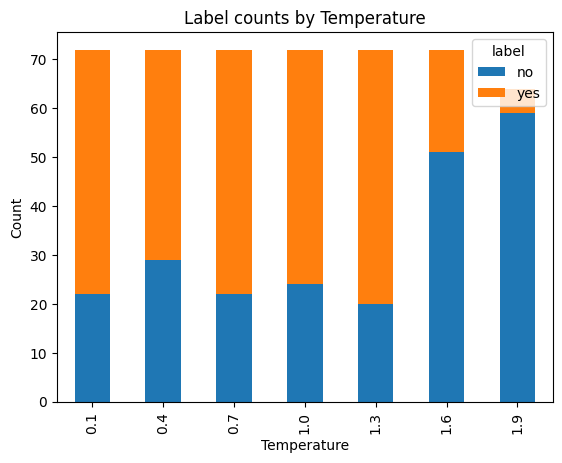

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_counts = result.groupby("temperature")["label"].value_counts().unstack()

grouped_counts.plot(kind="bar", stacked=True)
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.title("Label counts by Temperature")
plt.show()